In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/ml-100k")
import numpy as np
import pandas as pd
import torch
from torch import nn

In [ ]:
# 导入user-item交互矩阵
data = pd.read_csv("./user_item2.csv")
data.drop(data.columns[0], axis=1, inplace=True)
data

,user_id,item_id,rating
0,1,55,1
1,1,203,1
2,1,183,1
3,1,150,1
4,1,68,1
...,...,...,...
99995,943,427,1
99996,943,12,1
99997,943,284,0
99998,943,62,0


# 划分训练集和测试集

In [ ]:
import numpy as np

# 设置随机数生成器的种子
np.random.seed(0)
# 创建一个1到10000的数组
arr = np.arange(data.shape[0])
# 原地随机排列数组
np.random.shuffle(arr)
# 选择百分之多少的数据作为训练集
train_test_ratio = 0.9
# 打乱后的数组的前百分之train_test_ratio(i.e.90%)作为训练集对应的index
train_index = arr[:int(len(arr)*train_test_ratio)]
# 打乱后的数组的后百分之(1-train_test_ratio)(i.e.10%)作为测试集对应的index
test_index = arr[int(len(arr)*train_test_ratio):]
# 获取训练集和测试集
train_set = data.iloc[train_index,:]
test_set = data.iloc[test_index, :]

# 将训练集和测试集的每一行都变成一个元组，方便后续处理
train_set = [tuple(row) for row in train_set.itertuples(index=False, name=None)]
test_set = [tuple(row) for row in test_set.itertuples(index=False, name=None)]

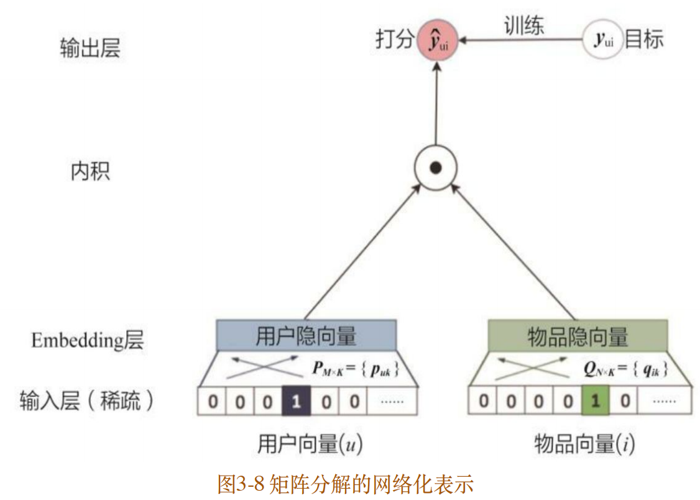

In [2]:
from PIL import Image
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/图片")
image_path = "./ALS.png"
image = Image.open(image_path)
new_size = (700, 500)
resized_image = image.resize(new_size)
resized_image

In [ ]:
# 限制embedding向量，即不采取措施抑制过拟合
'''
结果：
Epoch 9, Loss: 0.571901798248291
train: Precision 0.7336 | Recall 0.8520 | accuracy 0.7450
test: Precision 0.7228 | Recall 0.7868 | accuracy 0.7119
'''
class ALS(nn.Module):
  def __init__(self, num_users, num_items, hidden_dim):
    super(ALS, self).__init__()
    # Embedding层会给每一个user都分配一个长度为hidden_dim的隐向量
    self.user_Embedding = nn.Embedding(num_users, hidden_dim, max_norm = 1)
    # Embedding层会给每一个item都分配一个长度为num_factors的隐向量
    self.item_Embedding = nn.Embedding(num_items, hidden_dim, max_norm = 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, user, item):
    # user的维度为：num_users；user_embedding的维度为:(num_users, hidden_dim)
    user_embedding = self.user_Embedding(user)
    # item的维度为：num_items；item_embedding的维度为:(num_items, hidden_dim)
    item_embedding = self.item_Embedding(item)
    # user_embedding @ item_embedding.T的shape为(num_users, num_users)
    # 而在训练的时候，我们未必有对角线之外的元素的标签，所以这里只取对角线元素
    out = torch.diag(user_embedding @ item_embedding.T)
    sigmoid_out = self.sigmoid(out)
    return sigmoid_out

In [ ]:
# 不限制embedding向量，即不采取措施抑制过拟合
'''
结果：
Epoch 9, Loss: 0.002246593125164509
train: Precision 1.0000 | Recall 1.0000 | accuracy 1.0000
test: Precision 0.6163 | Recall 0.6290 | accuracy 0.5733
'''
class ALS_non_regularization(nn.Module):
  def __init__(self, num_users, num_items, hidden_dim):
    super(ALS_non_regularization, self).__init__()
    # Embedding层会给每一个user都分配一个长度为hidden_dim的隐向量
    self.user_Embedding = nn.Embedding(num_users, hidden_dim)
    # Embedding层会给每一个item都分配一个长度为num_factors的隐向量
    self.item_Embedding = nn.Embedding(num_items, hidden_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, user, item):
    # user的shape为(num_user); user_embedding的维度为:(num_users, hidden_dim)
    user_embedding = self.user_Embedding(user)
    # item的shape为(num_items); item_embedding的维度为:(num_items, hidden_dim)
    item_embedding = self.item_Embedding(item)
    # user_embedding @ item_embedding.T的shape为(num_users, num_users)
    # 而在训练的时候，我们未必有对角线之外的元素的标签，所以这里只取对角线元素
    out = torch.diag(user_embedding @ item_embedding.T)
    sigmoid_out = self.sigmoid(out)
    return sigmoid_out

In [ ]:
# 定义模型参数
# 加1的目的在于防止产生范围溢出错误
num_users = data.user_id.nunique() + 1; num_items = data.item_id.nunique() + 1
num_factors = 100

# 实例化模型
model = ALS(num_users, num_items, num_factors)

In [ ]:
def evaluation(y_pred, y_true):
  p = precision_score(y_true, y_pred)
  r = recall_score(y_true, y_pred)
  acc = accuracy_score(y_true,y_pred)
  return p,r,acc

In [ ]:
# 实例化损失函数和优化器
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score,recall_score,accuracy_score
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
  for user, item, rating in DataLoader(train_set, batch_size=512, shuffle=True):
    # 清空梯度
    optimizer.zero_grad()
    # 前向传播
    predictions = model(user, item)
    # 计算损失
    loss = loss_fn(predictions, rating.float())
    # 反向传播
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")

  # 训练集
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = rating.detach().numpy()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('train: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))

  #测试集
  user_test = torch.tensor(test_set)[:,0].detach()
  item_test = torch.tensor(test_set)[:,1].detach()
  predictions = model(user_test, item_test)
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = torch.tensor(test_set)[:,2].detach().float()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('test: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))
  print('----------------------------------------------------------------------------------------')

Epoch 0, Loss: 0.6114059686660767
train: Precision 0.7049 | Recall 0.7963 | accuracy 0.7100
test: Precision 0.7035 | Recall 0.7896 | accuracy 0.6961
----------------------------------------------------------------------------------------
Epoch 1, Loss: 0.6086801290512085
train: Precision 0.6908 | Recall 0.7818 | accuracy 0.6875
test: Precision 0.7220 | Recall 0.7952 | accuracy 0.7141
----------------------------------------------------------------------------------------
Epoch 2, Loss: 0.5947644710540771
train: Precision 0.7168 | Recall 0.7678 | accuracy 0.7175
test: Precision 0.7222 | Recall 0.7850 | accuracy 0.7108
----------------------------------------------------------------------------------------
Epoch 3, Loss: 0.5785040259361267
train: Precision 0.7349 | Recall 0.8551 | accuracy 0.7575
test: Precision 0.7178 | Recall 0.7889 | accuracy 0.7084
----------------------------------------------------------------------------------------
Epoch 4, Loss: 0.5873004198074341
train: Precisi